In [2]:
# !pip install transformers
# !pip install sentence-transformers

microsoft/SportsBERT model used for testing

In [3]:
import pandas as pd
import numpy as np
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import os, gc
gc.collect()
# torch.cuda.empty_cache()
# MODEL = "bert-base-uncased"
# MODEL = "distilbert-base-cased"
MODEL = "microsoft/SportsBERT"

In [4]:
# from stop_words import get_stop_words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

# stop_words = list(get_stop_words('en'))         #About 900 stopwords
nltk_words = list(stopwords.words('english')) #About 150 stopwords
print(nltk_words)
# stop_words.extend(nltk_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounting on google drive to run the code on colab

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')
# epl_1718 = pd.read_csv("/content/gdrive/MyDrive/NLP_project/senti_data.tsv", sep="\t")
# data = epl_1718[["HomeTeam","AwayTeam", "Season", "Result"]]
# allotment = pd.read_csv("/content/gdrive/MyDrive/NLP_project/allocated_sentences.csv", sep=",")
# display(allotment.tail(5))
# display(data.head(5))

Mounted at /content/gdrive


Data pre-processing for model development.
Please change the path below in the code to the destination where the file has been downloaded

In [6]:
def get_result(home, away):
  if home>away:
    return(2)
  elif home==away:
    return(1)
  else:
    return(0)

def get_season(seas):
  s = seas.split('/')
  return(int(s[1]))

def get_clean_commentary(c):
  s= c.split('.')
  cs = ""
  for i in s[:-1]:
    cs = cs+ i
  return(cs)

def get_sentence(ht, at, sent):
        sent = sent.replace(ht,"hometeam")
        sent = sent.replace(at, "awayteam")
        # for w in nltk_words:
        #   sent = sent.replace(" "+w+" ", " ")
        return(sent)

def get_val(x):
  # print(x)
  if x=="L":
    return(-1)
  elif x=="W":
    return(1)
  elif x=="D":
    return(0)
  return(0)

def get_prev_vec(x, team):
  vec = 0
  for i in range(5):
    dec = x[team+"M"+str(i+1)]
    vec += get_val(dec)
  return(vec/5.0)





data = pd.read_csv("/content/gdrive/MyDrive/NLP_project/replaced_commentary.tsv", sep="\t")
display(data.head(5))
data["Result"] = data.apply(lambda x: get_result(x["FTHG"], x["FTAG"]), axis=1)
data["Season"] = data.apply(lambda x: get_season(x["Season"]), axis=1)
data["prev_res_h"] = data.apply(lambda x: get_prev_vec(x,"H"), axis=1)
data["prev_res_a"] = data.apply(lambda x: get_prev_vec(x,"A"), axis=1)
data["Commentary"] = data.apply(lambda x: get_clean_commentary(x["Commentary"]), axis=1)
data["Commentary"] = data.apply(lambda x: get_sentence(x["HomeTeam"],x["AwayTeam"],x["Commentary"]), axis=1)
data = data[["HomeTeam", "AwayTeam","Season","Result","prev_res_h", "prev_res_a","Commentary"]]
display(data.head(5))
print(data.iloc[1,4])

,Unnamed: 0.1,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,...,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,Commentary,Season
0,0,0,22/02/2014,Arsenal,Sunderland,4,1,H,48,25,...,5.2,10.00,1.30,5.5,10.00,1.33,4.5,11.00,gus Sunderland says the excitement at Sunderla...,13/14
1,1,1,22/02/2014,Chelsea,Everton,1,0,H,48,37,...,4.0,6.10,1.57,4.0,6.00,1.60,3.4,7.00,before a reunion with didier drogba in midweek...,13/14
2,2,2,22/02/2014,Crystal Palace,Manchester United,0,2,NH,18,41,...,3.6,1.65,6.00,4.0,1.57,6.00,3.6,1.62,this promises to be an awkward test for Manche...,13/14
3,3,3,22/02/2014,Manchester City,Stoke City,1,0,H,69,27,...,7.0,15.00,1.18,7.0,15.00,1.20,6.0,15.00,this visit of Stoke City Manchester City is th...,13/14
4,4,4,22/02/2014,West Brom,Fulham,1,1,NH,30,26,...,3.5,4.20,1.80,3.6,4.33,1.80,3.5,4.50,felix Fulham has always been known as a tough ...,13/14


,HomeTeam,AwayTeam,Season,Result,prev_res_h,prev_res_a,Commentary
0,Arsenal,Sunderland,14,2,0.4,0.4,gus awayteam says the excitement at awayteam h...
1,Chelsea,Everton,14,2,0.6,-0.4,before a reunion with didier drogba in midweek...
2,Crystal Palace,Manchester United,14,0,0.2,-0.2,this promises to be an awkward test for awayte...
3,Manchester City,Stoke City,14,2,0.4,-0.2,this visit of awayteam hometeam is the last le...
4,West Brom,Fulham,14,1,-0.4,-0.8,felix awayteam has always been known as a toug...


0.6


Displaying the processed data

In [7]:
display(data.head(5))
print(data.iloc[1,4])

,HomeTeam,AwayTeam,Season,Result,prev_res_h,prev_res_a,Commentary
0,Arsenal,Sunderland,14,2,0.4,0.4,gus awayteam says the excitement at awayteam h...
1,Chelsea,Everton,14,2,0.6,-0.4,before a reunion with didier drogba in midweek...
2,Crystal Palace,Manchester United,14,0,0.2,-0.2,this promises to be an awkward test for awayte...
3,Manchester City,Stoke City,14,2,0.4,-0.2,this visit of awayteam hometeam is the last le...
4,West Brom,Fulham,14,1,-0.4,-0.8,felix awayteam has always been known as a toug...


0.6


In [ ]:
# data["Result"] += 1
# display(data.head(5))

Dataloader class

In [8]:
class BertDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        super(BertDataset, self).__init__()
        self.data = data
        self.tokenizer=tokenizer
        self.max_length=max_length
        
    def __len__(self):
        return len(self.data)
      
    def get_sentence(self, ht, at, sent):
        sent = sent.replace(ht,"home team")
        sent = sent.replace(at, "away team")
        # for w in nltk_words:
        #   sent = sent.replace(w, " ")
        return(sent)

    
    def __getitem__(self, index):
        
        text1 = self.data.iloc[index,6]
        
        inputs = self.tokenizer.encode_plus(text1, padding='max_length',max_length=self.max_length, return_attention_mask=True)

        return {'token': torch.tensor(inputs["input_ids"]),
                'mask':torch.tensor(inputs["attention_mask"]),
                'target': torch.tensor(self.data.iloc[index,3], dtype=torch.long),
                'prev_h':torch.tensor([self.data.iloc[index,4]]).float(),
                'prev_a':torch.tensor([self.data.iloc[index,5]]).float()
        }

adding awayteam and hometeam labels

In [9]:
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL,do_lower_case=True, add_special_tokens=True,)
tokenizer.add_tokens(["hometeam", "awayteam"])
tokenizer_len = len(tokenizer)

In [10]:
print(len(tokenizer))

10002


Train Test split

In [11]:
train_data = shuffle(data[(data["Season"]!=18)])
test_data = data[(data["Season"]==18)]
print(len(train_data), len(test_data))

1021 277


Checking data imbalances

In [12]:
display(train_data.groupby(["Result"]).count())
display(test_data.groupby(["Result"]).count())
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_data["Result"].to_numpy()), y = train_data["Result"].to_numpy())
print(class_weights)

,HomeTeam,AwayTeam,Season,prev_res_h,prev_res_a,Commentary
Result,,,,,,
0,316,316,316,316,316,316
1,235,235,235,235,235,235
2,470,470,470,470,470,470


,HomeTeam,AwayTeam,Season,prev_res_h,prev_res_a,Commentary
Result,,,,,,
0,78,78,78,78,78,78
1,71,71,71,71,71,71
2,128,128,128,128,128,128


[1.07700422 1.44822695 0.72411348]


Getting balanced data

In [13]:
balance_len = 234
l = train_data[train_data["Result"]==0].sample(balance_len)
w = train_data[train_data["Result"]==2].sample(balance_len)
d = train_data[train_data["Result"]==1]
train_data = pd.concat([l,w,d], ignore_index=True, sort=False)[:696]
display(len(train_data))

696

In [14]:
display(train_data.groupby(["Result"]).count())
display(test_data.groupby(["Result"]).count())
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_data["Result"].to_numpy()), y = train_data["Result"].to_numpy())
print(class_weights)

,HomeTeam,AwayTeam,Season,prev_res_h,prev_res_a,Commentary
Result,,,,,,
0,234,234,234,234,234,234
1,228,228,228,228,228,228
2,234,234,234,234,234,234


,HomeTeam,AwayTeam,Season,prev_res_h,prev_res_a,Commentary
Result,,,,,,
0,78,78,78,78,78,78
1,71,71,71,71,71,71
2,128,128,128,128,128,128


[0.99145299 1.01754386 0.99145299]


Creating train and test data loaders

In [15]:
train_dataset = BertDataset(train_data, tokenizer, max_length=300)
train_loader=DataLoader(dataset=train_dataset,batch_size=8, shuffle=True)

test_dataset = BertDataset(test_data, tokenizer, max_length=300)
test_loader=DataLoader(dataset=test_dataset,batch_size=8, shuffle=True)

In [16]:
class BERT(nn.Module):
    def __init__(self, tokenizer_len):
        super(BERT, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained(MODEL)
        self.bert_model.resize_token_embeddings(tokenizer_len)
        for param in self.bert_model.parameters():
          param.requires_grad = True
        self.batch_norm = nn.BatchNorm1d(768)
        self.batch_norm1 = nn.BatchNorm1d(100)
        self.batch_norm2 = nn.BatchNorm1d(10)
        self.fc1 = nn.Linear(768,10)
        self.fc2 = nn.Linear(100,10)
        self.fc3 = nn.Linear(10, 3)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
    def forward(self,token, mask):
        o2= self.bert_model(token, attention_mask = mask).pooler_output
        out = self.batch_norm(o2)
        out= self.tanh(self.fc1(out)) #[:,0,:])  
        out = self.fc3(out) 
        
        return out
    


In [17]:
model=BERT(tokenizer_len)
weights = torch.tensor(class_weights).float()
weights = weights.to(device)
# loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()

#Initialize Optimizer


Some weights of the model checkpoint at microsoft/SportsBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at microsoft/SportsBERT and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
Y

In [18]:
# lr = 0.0001
optimizer= optim.Adam(model.parameters(),lr= 1e-7)
# model.config

In [19]:
# for param in model.bert_model.parameters():
#     param.requires_grad = False

train_accuracy = []
test_accuracy = []
train_loss = []

# metric = MulticlassF1Score(num_classes=3)
# metric = metric.to(device)

In [20]:
def finetune(epochs,dataloader,test_loader, model,loss_fn,optimizer):
    model = model.to(device)
    
    model.train()
    for  epoch in range(epochs):
        # print(epoch)
        
        # loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
        # model.train()
        global_acc = []
        global_loss = []
        global_test = []
        
        global_f1_tr = []
        global_prec_tr = []
        global_recall_tr = []

        global_f1_te = []
        global_prec_te = []
        global_recall_te = []

        for batch, dl in enumerate(dataloader):
            # print(dl)
            token = dl["token"].to(device)
            mask = dl["mask"].to(device)
            label=dl['target'].to(device)
            # print(mask)
            if label.shape[0]!=1:
              label = label.squeeze(dim=-1).to(device)
            # print(label)
            
            optimizer.zero_grad()
            
            output=model(token, mask)
            # label = label.type_as(output)
            # print(label.shape)   
            # output = output.squeeze(dim=-1) 
            # print(output.shape, label.shape)
            # output = output.float()
            # label = label.float()
          
            loss=loss_fn(output,label) #+(0.1/torch.sum((0.5-output)**2))

            loss.backward()
            
            optimizer.step()
            
            
            # pred = torch.where(output>=0.5, 1,0)
            _, pred = torch.max(output, axis=1)
            # print(pred.shape, label.shape)
            accuracy = torch.mean((pred==label).float())
            pred = pred.cpu()
            label=label.cpu()
            f1 = f1_score(label, pred, average='micro', zero_division=0)
            prec = precision_score(label, pred, average='micro', zero_division=0)
            recall = recall_score(label, pred, average='micro', zero_division=0)
            global_f1_tr.append(f1)
            global_prec_tr.append(prec)
            global_recall_tr.append(recall)
            print("Tr: ",pred, label)
            print("Tr: ", accuracy.item(), f1, prec, recall)
            # print("Epoc: %d , Batch: %d Acuracy: %.3f"%(epoch, batch, accuracy.item()))
            global_acc.append(accuracy.item())
            global_loss.append(loss.item())
        
        model.eval()
        
        for i, dl in enumerate(test_loader):
            with torch.no_grad():
              token = dl["token"].to(device)
              mask = dl["mask"].to(device)
              label=dl['target'].to(device)

              # if label.shape[0]!=1:
              #   label = label.squeeze().to(device)
              # else:
              # label = torch.reshape(label, (-1,1))

              # label = label.squeeze().to(device)
              
              output=model(token, mask)
              # pred = torch.where(output>=0.5, 1,0)
              _, pred = torch.max(output, axis=1)
              pred = torch.reshape(pred, (-1,))  
              
              accuracy = torch.mean((pred==label).float())
              pred = pred.cpu()
              label=label.cpu()
              f1 = f1_score(label, pred, average='micro', zero_division=0)
              prec = precision_score(label, pred, average='micro', zero_division=0)
              recall = recall_score(label, pred, average='micro', zero_division=0)
              global_f1_te.append(f1)
              global_prec_te.append(prec)
              global_recall_te.append(recall)
              print("Te: ",pred, label)
              print("Te: ", accuracy.item(), f1, prec, recall)
              global_test.append(accuracy.item())

        mean_loss = sum(global_loss)/len(global_loss)
        mean_train_acc = sum(global_acc)/len(global_acc)
        mean_test_acc = sum(global_test)/len(global_test)
        m_tr_f1 = sum(global_f1_tr)/len(global_f1_tr)
        m_tr_prec = sum(global_prec_tr)/len(global_prec_tr)
        m_tr_recall = sum(global_recall_tr)/len(global_recall_tr)

        m_te_f1 = sum(global_f1_te)/len(global_f1_te)
        m_te_prec = sum(global_prec_te)/len(global_prec_te)
        m_te_recall = sum(global_recall_te)/len(global_recall_te)

        train_accuracy.append(mean_train_acc)
        test_accuracy.append(mean_test_acc)
        train_loss.append(mean_loss)

        print("Epoc: %d \tLoss: %.3f \tTrain Acuracy: %.3f \tTest Accuracy: %.3f"%(epoch, mean_loss, mean_train_acc, mean_test_acc))
        print("Train: Epoc: %d \tF1: %.3f \tprec: %.3f \trecall: %.3f"%(epoch, m_tr_f1, m_tr_prec, m_tr_recall))
        print("Test: Epoc: %d \tF1: %.3f \tprec: %.3f \trecall: %.3f"%(epoch, m_te_f1, m_te_prec, m_te_recall))
          

            # num_correct = sum(1 for a, b in zip(pred, label) if a[0] == b[0])
            # num_samples = pred.shape[0]
            # accuracy = num_correct/num_samples
            
            # print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
            
            # Show progress while training
            # loop.set_description(f'Epoch={epoch}/{epochs}')
            # loop.set_postfix(loss=loss.item(),acc=accuracy.item())

    return model

If want to see the training, please uncomment the next line to see the bert getting trained.
Run for 50 epochs.

In [ ]:
# model = finetune(25, train_loader, test_loader, model, loss_fn, optimizer)

Streaming output truncated to the last 5000 lines.
Te:  0.375 0.375 0.375 0.375
Te:  tensor([2, 0, 1, 0, 2, 1, 2, 0]) tensor([2, 2, 2, 0, 2, 1, 1, 0])
Te:  0.625 0.625 0.625 0.625
Te:  tensor([2, 2, 0, 0, 0, 0, 1, 1]) tensor([1, 1, 2, 2, 1, 0, 2, 1])
Te:  0.25 0.25 0.25 0.25
Te:  tensor([2, 0, 1, 0, 2, 1, 0, 0]) tensor([2, 0, 1, 2, 1, 0, 1, 0])
Te:  0.5 0.5 0.5 0.5
Te:  tensor([2, 2, 2, 0, 1, 2, 1, 0]) tensor([2, 1, 2, 1, 1, 2, 2, 2])
Te:  0.5 0.5 0.5 0.5
Te:  tensor([0, 2, 2, 1, 2, 0, 2, 2]) tensor([0, 0, 1, 0, 2, 0, 0, 1])
Te:  0.375 0.375 0.375 0.375
Te:  tensor([2, 2, 0, 1, 2, 0, 0, 0]) tensor([1, 1, 1, 2, 1, 1, 0, 0])
Te:  0.25 0.25 0.25 0.25
Te:  tensor([1, 1, 0, 0, 1, 1, 1, 1]) tensor([0, 2, 0, 0, 2, 2, 2, 2])
Te:  0.25 0.25 0.25 0.25
Te:  tensor([2, 0, 2, 0, 0, 2, 2, 0]) tensor([0, 1, 2, 1, 0, 0, 1, 2])
Te:  0.25 0.25 0.25 0.25
Te:  tensor([0, 2, 1, 0, 2, 0, 2, 0]) tensor([1, 2, 1, 1, 0, 2, 2, 1])
Te:  0.375 0.375 0.375 0.375
Te:  tensor([0, 2, 2, 2, 1, 1, 0, 1]) tensor([2, 2, 

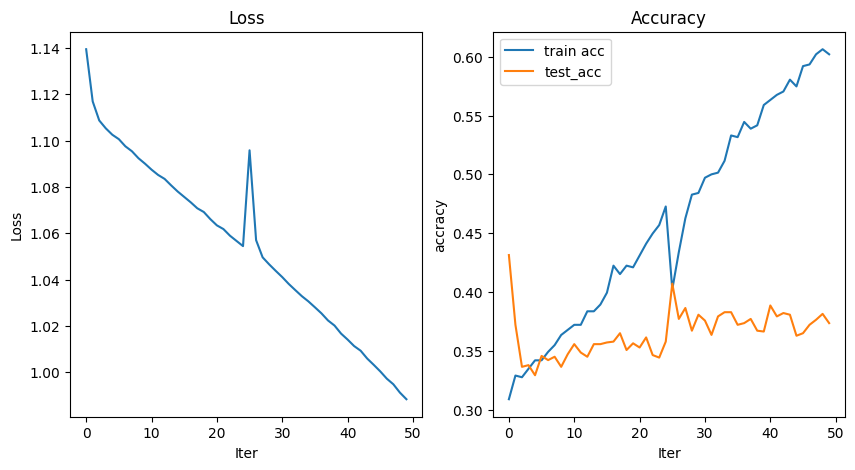

In [ ]:
import matplotlib.pyplot as plt
# train_accuracy = []
# test_accuracy = []
# train_loss = []

x = np.arange(len(train_loss))
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10, 5))
cp1 = ax1.plot(x, train_loss)
ax1.set_title('Loss')
ax1.set_xlabel('Iter')
ax1.set_ylabel('Loss')

ax2.plot(x, train_accuracy)
ax2.plot(x, test_accuracy)
ax2.set_title('Accuracy')
ax2.set_xlabel('Iter')
ax2.set_ylabel('accracy')
ax2.legend(("train acc", "test_acc"))
plt.show()


In [ ]:
# torch.save(model.state_dict(), "/content/gdrive/MyDrive/NLP_project/bert_model_3classoutput")

For test run

In [22]:
text = "Manchester United's odd league campaign will have them end in second place whatever the result versus Watford despite jose Manchester United ' s side rarely exciting or convincing . the visitors arrive safe in 13th and could end as high as 10th should they beat Manchester United and , given Watford's victory at old Manchester United in april , they may fancy their chances ."
text = text.replace("Manchester United", "hometeam")
text = text.replace("Watford", "awayteam")
model.load_state_dict(torch.load("/content/gdrive/MyDrive/NLP_project/bert_model_3classoutput", map_location=device))
inputs = tokenizer.encode_plus(text ,padding='max_length',max_length=300,return_attention_mask=True )
tokens = torch.tensor(inputs["input_ids"])
mask = torch.tensor(inputs["attention_mask"])
tokens = torch.tensor(tokens).unsqueeze(0)
mask = torch.tensor(mask).unsqueeze(0)
tokens = tokens.to(device)
mask = mask.to(device)
model = model.to(device)
model.eval()
output=model(tokens, mask)
print(output)

<ipython-input-22-a2f32040963c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens).unsqueeze(0)
<ipython-input-22-a2f32040963c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask).unsqueeze(0)


tensor([[-0.1343,  0.1271, -0.1098]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
